# Quantum Compiler Performance Comparison for IonQ

This notebook compares the performance of different quantum circuit compilation approaches when targeting IonQ quantum computing devices. We evaluate 5 different compilation strategies and measure their effectiveness using circuit metrics and simulation performance. This will serve as an initial use case for prototyping HW-aware compilation support for UCC (which would ultimately extend beyond just IonQ).

## Context & Purpose
IonQ provides a [Qiskit backend](https://github.com/qiskit-community/qiskit-ionq) to simplify submitting circuits to their cloud simulator and devices. These circuits can be comprised of QIS gates or IonQ device native gates [see docs](https://docs.ionq.com/guides/getting-started-with-native-gates). If circuits are submitted with QIS gates ( which are the typical/common gates in the literature), IonQ cloud will use their proprietary compiler to optimize to instead run on their HW. If circuits are submitted with native gates, IonQ cloud will effectively run those verbatim. For users that want to understand and have some control over the optimization of their circuits, this leaves a gap. Although the qiskit backend has support for transpiling a circuit to native gates, it doesn't do any meaningful optimization. For users that want visibility and control in how their circuits are optimized, this leaves a gap.

## Initial Goal
The initial goal is to identify a non-trival circuit where using UCC with the qiskit-ionq backend gives **worse** performance than relying on the proprietary IonQ cloud compiler. This would give a starting point for prototying improvements.

### Compilation Approaches Tested
We include Qiskit as well to see how UCC customizations differ (or don't differ) from stock Qiskit.
1. **Original (Uncompiled, QIS Gates)**
2. **UCC (Default, QIS Gates)**
3. **UCC (IonQ Backend, Native Gates)**
4. **Qiskit (Opt Level 3, QIS Gates)**
5. **Qiskit (Opt Level 3, IonQ Backend, Native Gates)**

## Metrics
- Circuit structure: width, depth, gate counts
- Performance: Total Variation Distance in measurement distributions when simulated using IonQ Aria-1 cloud simulator

### Setup
* Run `uv sync` from this notebook's directory to install dependencies. We are using Qiskit < 2 as the qiskit_ionq provider is really not updated for Qiskit 2.0
* Create a `.env` file with IonQ cloud API key:
```
IONQ_API_KEY="<key>"
```

In [1]:
# .env file has IONQ_API_KEY
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from typing import Dict, Any

from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import QFT
from qiskit.quantum_info import Statevector
from qiskit.circuit.random import random_circuit
from qiskit.providers.backend_compat import BackendV2Converter
import qiskit_ionq
import ucc
import os

/Users/bchase/code/unitaryfoundation.research/ucc-hw-aware/.venv/lib/python3.13/site-packages/qbraid/_entrypoints.py:20: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [ ]:
TEST_CIRCUIT_QUBITS = 4
TEST_CIRCUIT_TYPE = "random-depth3"  # Options: "GHZ", "random-depthN", "QFT"
SEED = 1776  # 42  # seed for random circuit
NOISE_MODEL = "aria-1"  # Options: "ideal", "aria-1"
NUM_SHOTS = 5000

In [4]:
ionq_provider = qiskit_ionq.IonQProvider(os.getenv("IONQ_API_KEY"))
ionq_qis_gates = [
    "id",
    "x",
    "y",
    "x",
    "rx",
    "ry",
    "rz",
    "h",
    "cx",
    "s",
    "si",
    "t",
    "ti",
    "v",
    "vi",
    "swap",
]


## 1. Test Circuit Creation

Create the base test circuit that will be compiled using different approaches.

In [5]:
def create_test_circuit(num_qubits: int, circuit_type: str = "QFT") -> QuantumCircuit:
    """
    Create test circuit for compilation comparison.

    Args:
        num_qubits: Number of qubits in the circuit
        circuit_type: Type of circuit to create ("QFT", "Random", etc.)

    Returns:
        QuantumCircuit: The test circuit
    """
    if circuit_type == "GHZ":
        qc = QuantumCircuit(num_qubits)
        qc.h(0)
        for i in range(1, num_qubits):
            qc.cx(0, i)
    elif circuit_type == "QFT":
        # Create QFT circuit with measurements
        qc = QFT(
            num_qubits,
            approximation_degree=0,
            do_swaps=True,
            inverse=False,
            insert_barriers=False,
            name="qft",
        )
    elif circuit_type.startswith("random"):
        # Support 'random-depthN' (e.g., random-depth10) or just 'random' (default depth 3)
        import re

        match = re.match(r"random(?:-depth(\d+))?", circuit_type)
        if match and match.group(1):
            depth = int(match.group(1))
        else:
            depth = 3
        qc = random_circuit(num_qubits, depth, seed=SEED, measure=True)
        qc = transpile(
            qc, basis_gates=["id", "rx", "ry", "rz", "cx"], optimization_level=1
        )
    else:
        raise ValueError(f"Circuit type '{circuit_type}' not implemented yet")

    return qc


# Create the original test circuit
original_circuit = create_test_circuit(TEST_CIRCUIT_QUBITS, TEST_CIRCUIT_TYPE)

print(f"✓ Original {TEST_CIRCUIT_TYPE} circuit created")
print(f"  Qubits: {original_circuit.num_qubits}")
print(f"  Depth: {original_circuit.depth()}")
print(f"  Gates: {sum(original_circuit.count_ops().values())}")

# Display the circuit (first few gates)
print("\nCircuit structure:")
print(original_circuit.draw(fold=-1))

✓ Original random-depth3 circuit created
  Qubits: 4
  Depth: 43
  Gates: 60

Circuit structure:
global phase: 3.2398
     ┌──────────┐     ┌───┐┌─────────┐                                             ┌───┐┌───────────┐                                   ┌───┐┌──────────┐                                                                                                                     ┌─────────┐                                                                                                                                ┌──────────┐┌─┐   
q_0: ┤ Rz(-π/2) ├─────┤ X ├┤ Rz(π/2) ├─────────────────────────────────────────────┤ X ├┤ Rz(-π/16) ├──■────────────────■───────────────┤ X ├┤ Rz(π/16) ├──■─────────────────■────■───────────────────────────────────────────────────────────────────────────────────────■───┤ Rx(π/2) ├───────────────────────────────────────────────────────────────────────────────────────────────────────■─────────────────────■──┤ Rx(-π/2) ├┤M├───
     └──┬───┬───┘     └─┬─

## 2. Circuit Analysis Functions

Helper functions to extract circuit metrics and compare performance.

In [6]:
def analyze_circuit_metrics(circuit: QuantumCircuit) -> Dict[str, Any]:
    """
    Extract key metrics from a quantum circuit.

    Args:
        circuit: QuantumCircuit to analyze

    Returns:
        Dict with circuit metrics
    """
    gate_counts = circuit.count_ops()
    total_gates = sum(gate_counts.values())

    # Count 2-qubit gates (IonQ native and common gates)
    two_qubit_gates = [
        "cx",
        "cy",
        "cz",
        "cp",
        "crx",
        "cry",
        "crz",
        "csx",
        "swap",
        "iswap",
        "ms",
        "zz",
        "rxx",
        "ryy",
        "rzz",
    ]
    num_two_qubit = sum(gate_counts.get(gate, 0) for gate in two_qubit_gates)

    # Count IonQ native gates specifically
    ionq_native_gates = ["gpi", "gpi2", "ms", "zz"]
    num_native = sum(gate_counts.get(gate, 0) for gate in ionq_native_gates)

    return {
        "width": circuit.num_qubits,
        "depth": circuit.depth(),
        "total_gates": total_gates,
        "two_qubit_gates": num_two_qubit,
        "native_gates": num_native,
        "gate_counts": dict(gate_counts),
        "single_qubit_gates": total_gates - num_two_qubit,
    }


def exact_probs(circuit, num_shots):
    sv = Statevector(circuit)
    return {int(k, base=2): v for k, v in sv.probabilities_dict().items()}


def simulate_circuit(circuit, gateset, num_shots, noise_model):
    """
    Simulate a quantum circuit in IonQ remote simulator

    Args:
        circuit: QuantumCircuit to simulate
        gateset: Gateset to use for the simulation ("native" or "qis")
        NUM_SHOTS: Number of shots for the simulation

    Returns:
        Dict with measurement counts
    """
    qpu_backend = ionq_provider.get_backend("ionq_simulator", gateset=gateset)
    job = qpu_backend.run(
        circuit,
        shots=num_shots,
        noise_model=noise_model,
        error_mitigation=qiskit_ionq.ErrorMitigation.NO_DEBIASING,
    )
    counts = job.result().get_counts()
    return {int(key, base=2): count / num_shots for key, count in counts.items()}


def calculate_total_variation_distance(
    probs1: Dict, probs2: Dict, num_shots: int
) -> float:
    """
    Calculate Total Variation Distance between two probability distributions.

    Args:
        probs1, probs2: Probability dictionaries

    Returns:
        Total variation distance (0 = identical, 1 = completely different)
    """

    all_outcomes = set(probs1.keys()) | set(probs2.keys())

    tvd = 0.5 * sum(
        abs(probs1.get(outcome, 0) - probs2.get(outcome, 0)) for outcome in all_outcomes
    )

    return tvd


## Can be provided to qiskit transpile to extract information on a circuit
def callback_func(**kwargs):
    from qiskit.converters import dag_to_circuit

    pass_ = kwargs["pass_"]
    dag = kwargs["dag"]
    print(f"Pass: {pass_.name()}")
    print(analyze_circuit_metrics(dag_to_circuit(dag)))
    # print(dag_to_circuit(dag))
    print("-" * 80)

## 3. Compilation Approaches

In [7]:
compiled_circuits = {}
gateset = {}  # whether the circuit is "qis" or "native" gateset
circuit_metrics = {}
simulation_results = {}

### Approach 1: Original (Uncompiled, QIS Gates)

✓ Approach 1: Original (Uncompiled, QIS Gates)
  Depth: 43
  Gates: 60
  2-qubit gates: 25


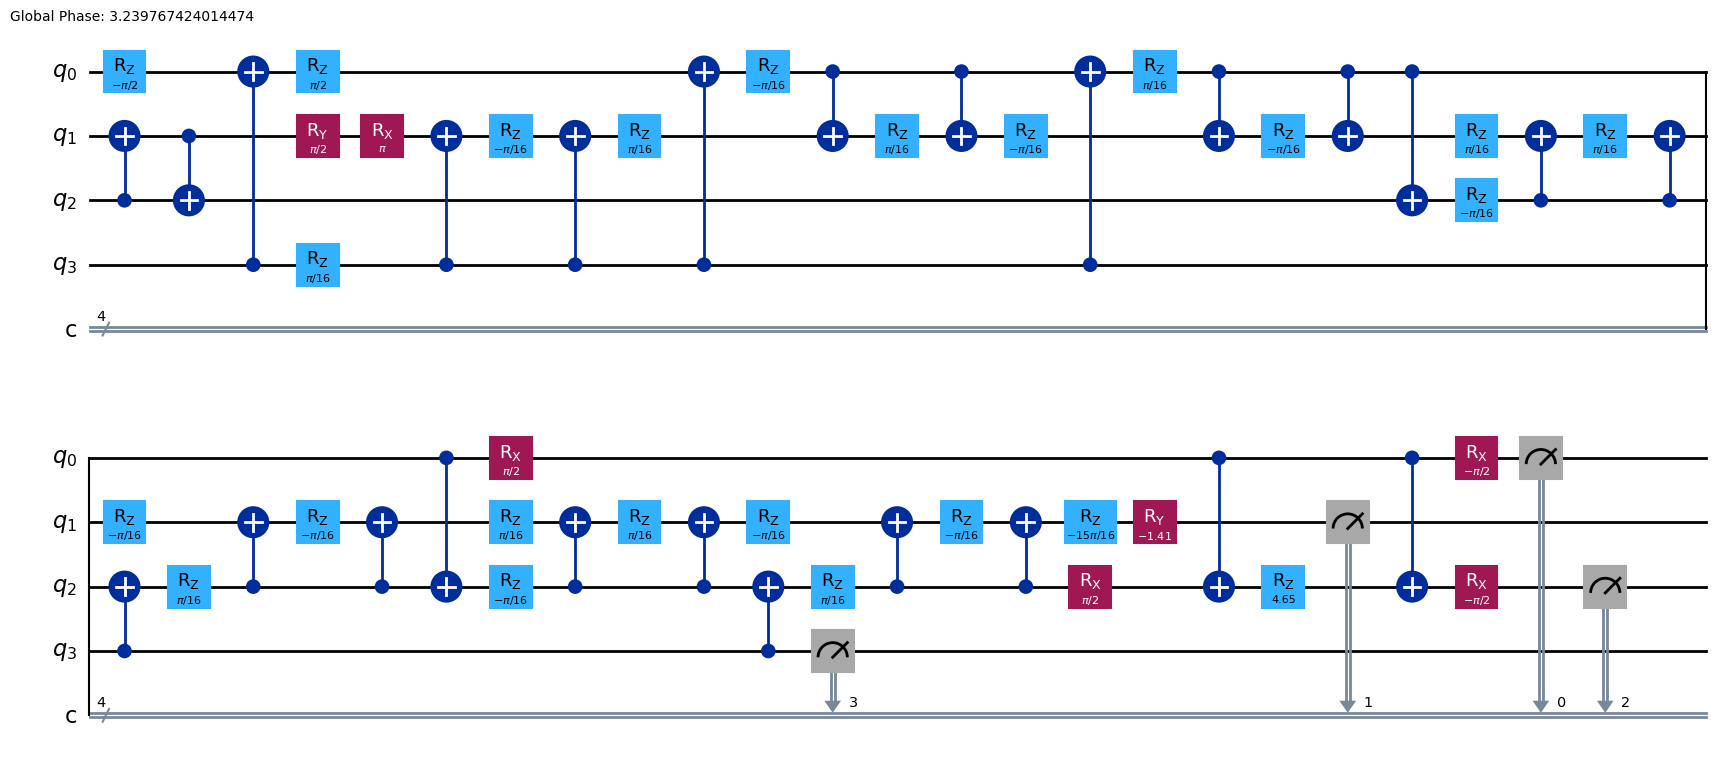

In [8]:
approach_name = "1_original_uncompiled_qis"


# Store original circuit
compiled_circuits[approach_name] = original_circuit.copy()
gateset[approach_name] = "qis"
circuit_metrics[approach_name] = analyze_circuit_metrics(original_circuit)


print(f"✓ Approach 1: Original (Uncompiled, QIS Gates)")
print(f"  Depth: {circuit_metrics[approach_name]['depth']}")
print(f"  Gates: {circuit_metrics[approach_name]['total_gates']}")
print(f"  2-qubit gates: {circuit_metrics[approach_name]['two_qubit_gates']}")
original_circuit.draw(output="mpl")

### Approach 2: UCC (Default, QIS Gates)

✓ Approach 2: UCC (Default, QIS Gates)
  Depth: 116
  Gates: 206
  2-qubit gates: 25


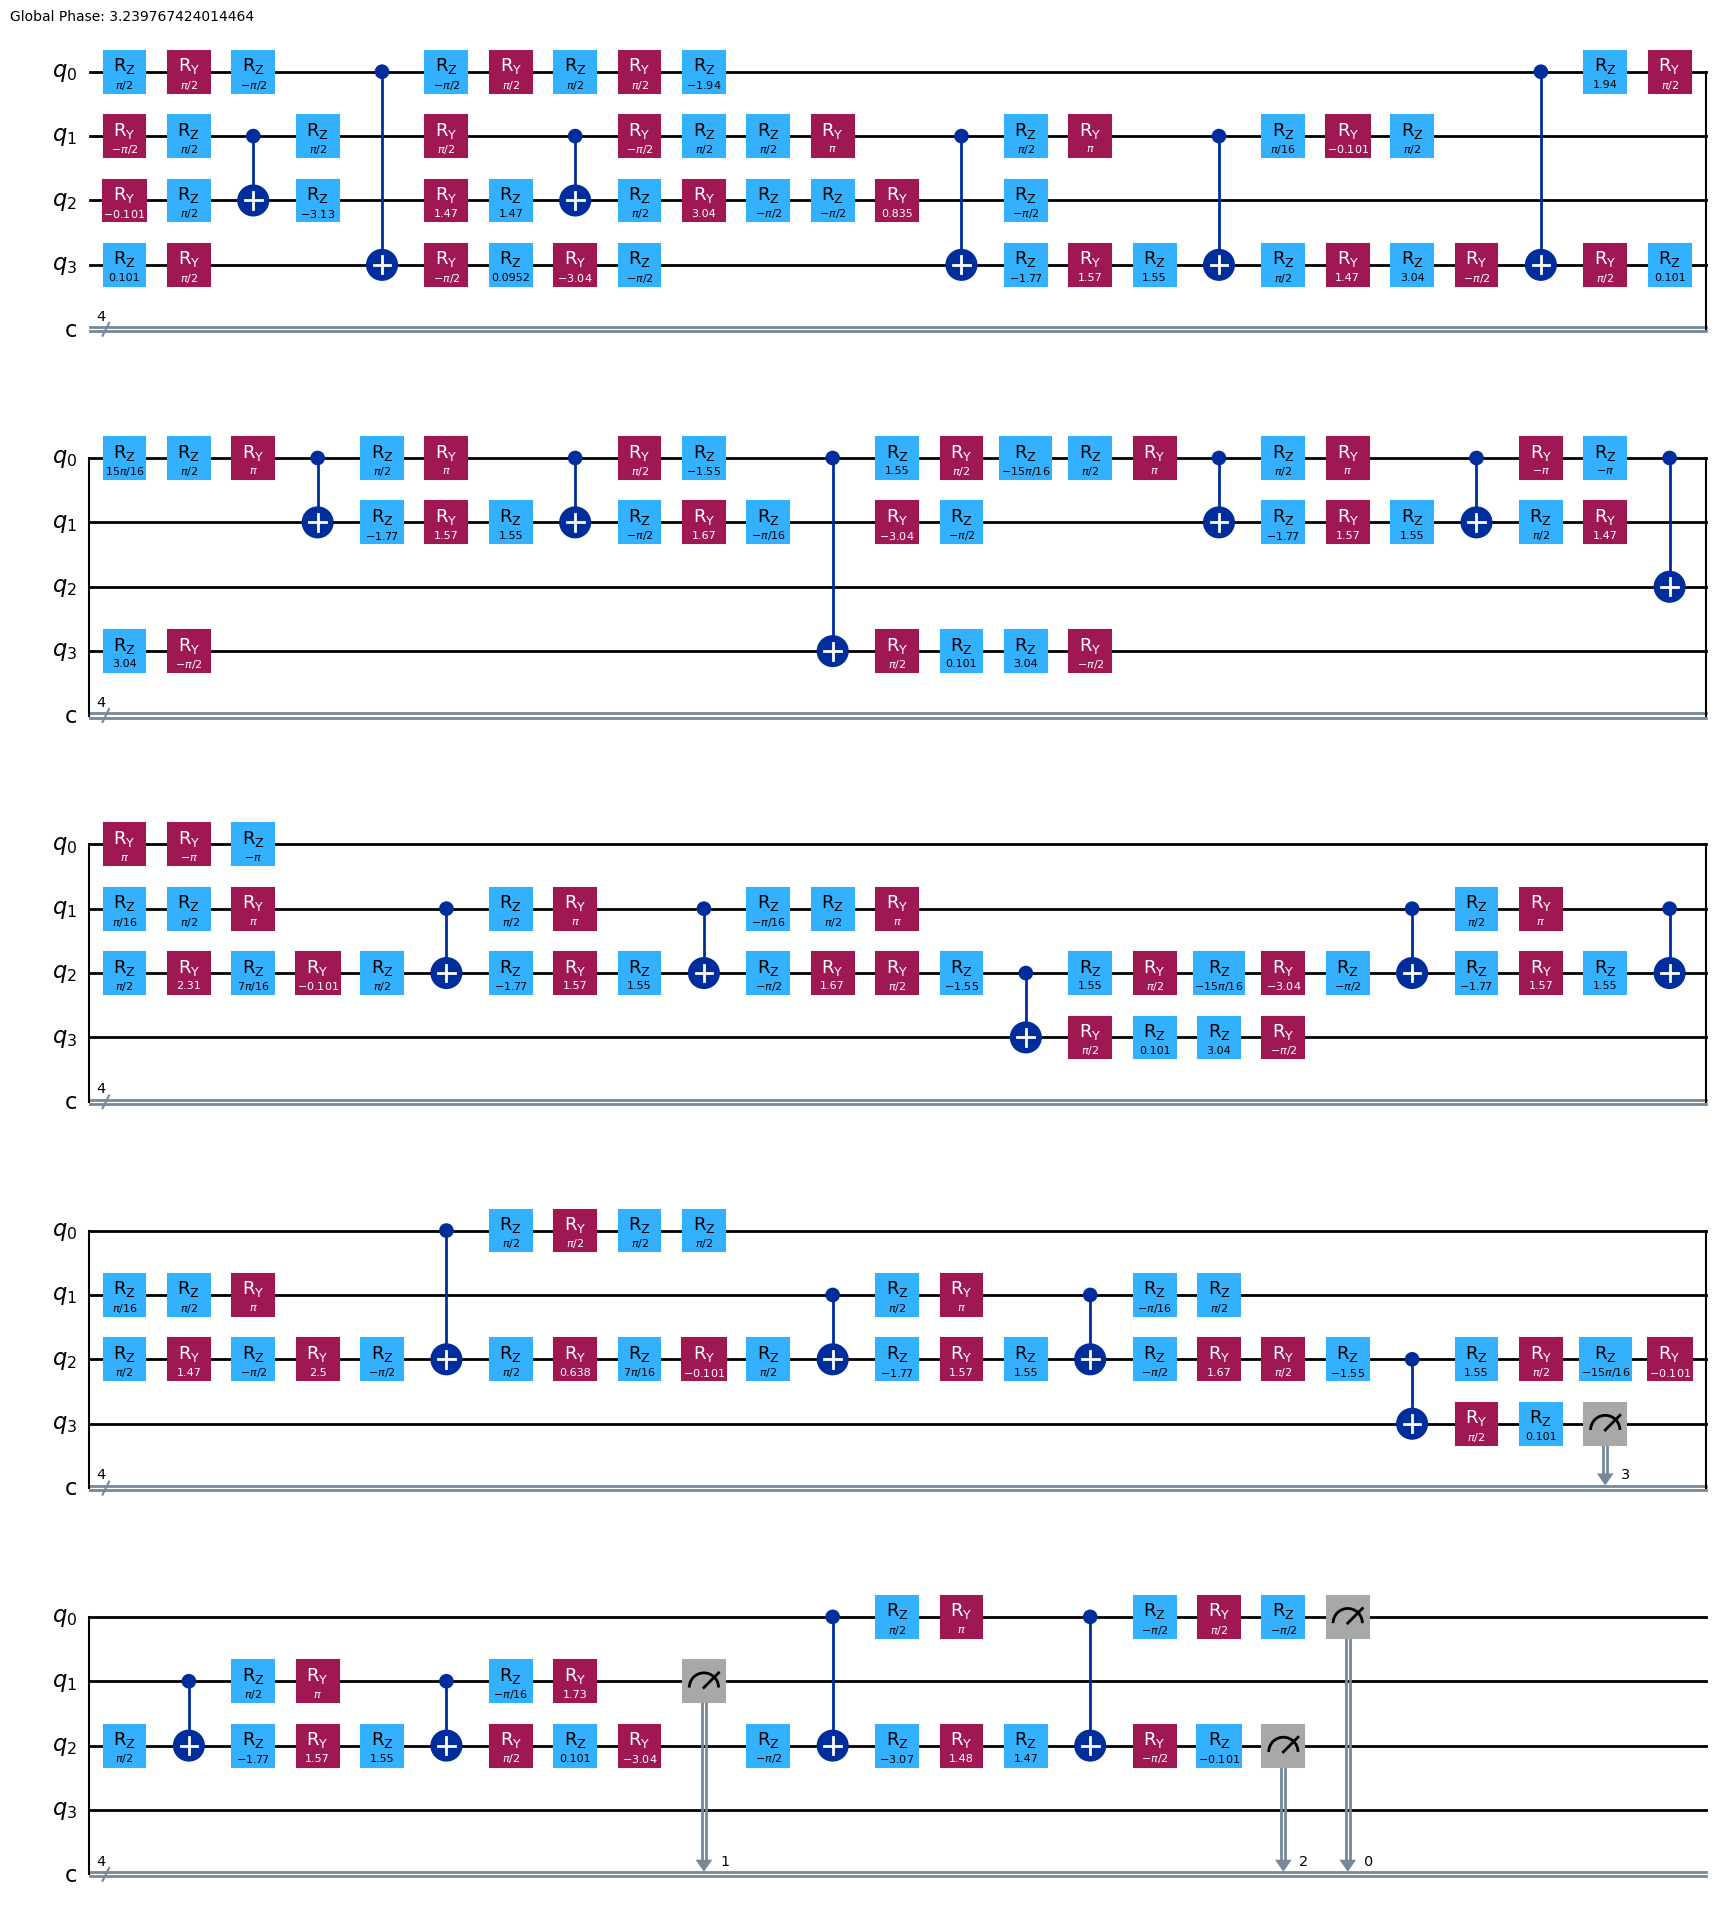

In [9]:
approach_name = "2_ucc_default_qis"


ucc_circuit = ucc.compile(original_circuit)


compiled_circuits[approach_name] = ucc_circuit
gateset[approach_name] = "qis"
circuit_metrics[approach_name] = analyze_circuit_metrics(ucc_circuit)


print(f"✓ Approach 2: UCC (Default, QIS Gates)")
print(f"  Depth: {circuit_metrics[approach_name]['depth']}")
print(f"  Gates: {circuit_metrics[approach_name]['total_gates']}")
print(f"  2-qubit gates: {circuit_metrics[approach_name]['two_qubit_gates']}")
ucc_circuit.draw(output="mpl")

### Approach 3: UCC (IonQ Backend, Native Gates)

✓ Approach 3: UCC (IonQ Backend, Native Gates)
  Depth: 338
  Gates: 660
  2-qubit gates: 25


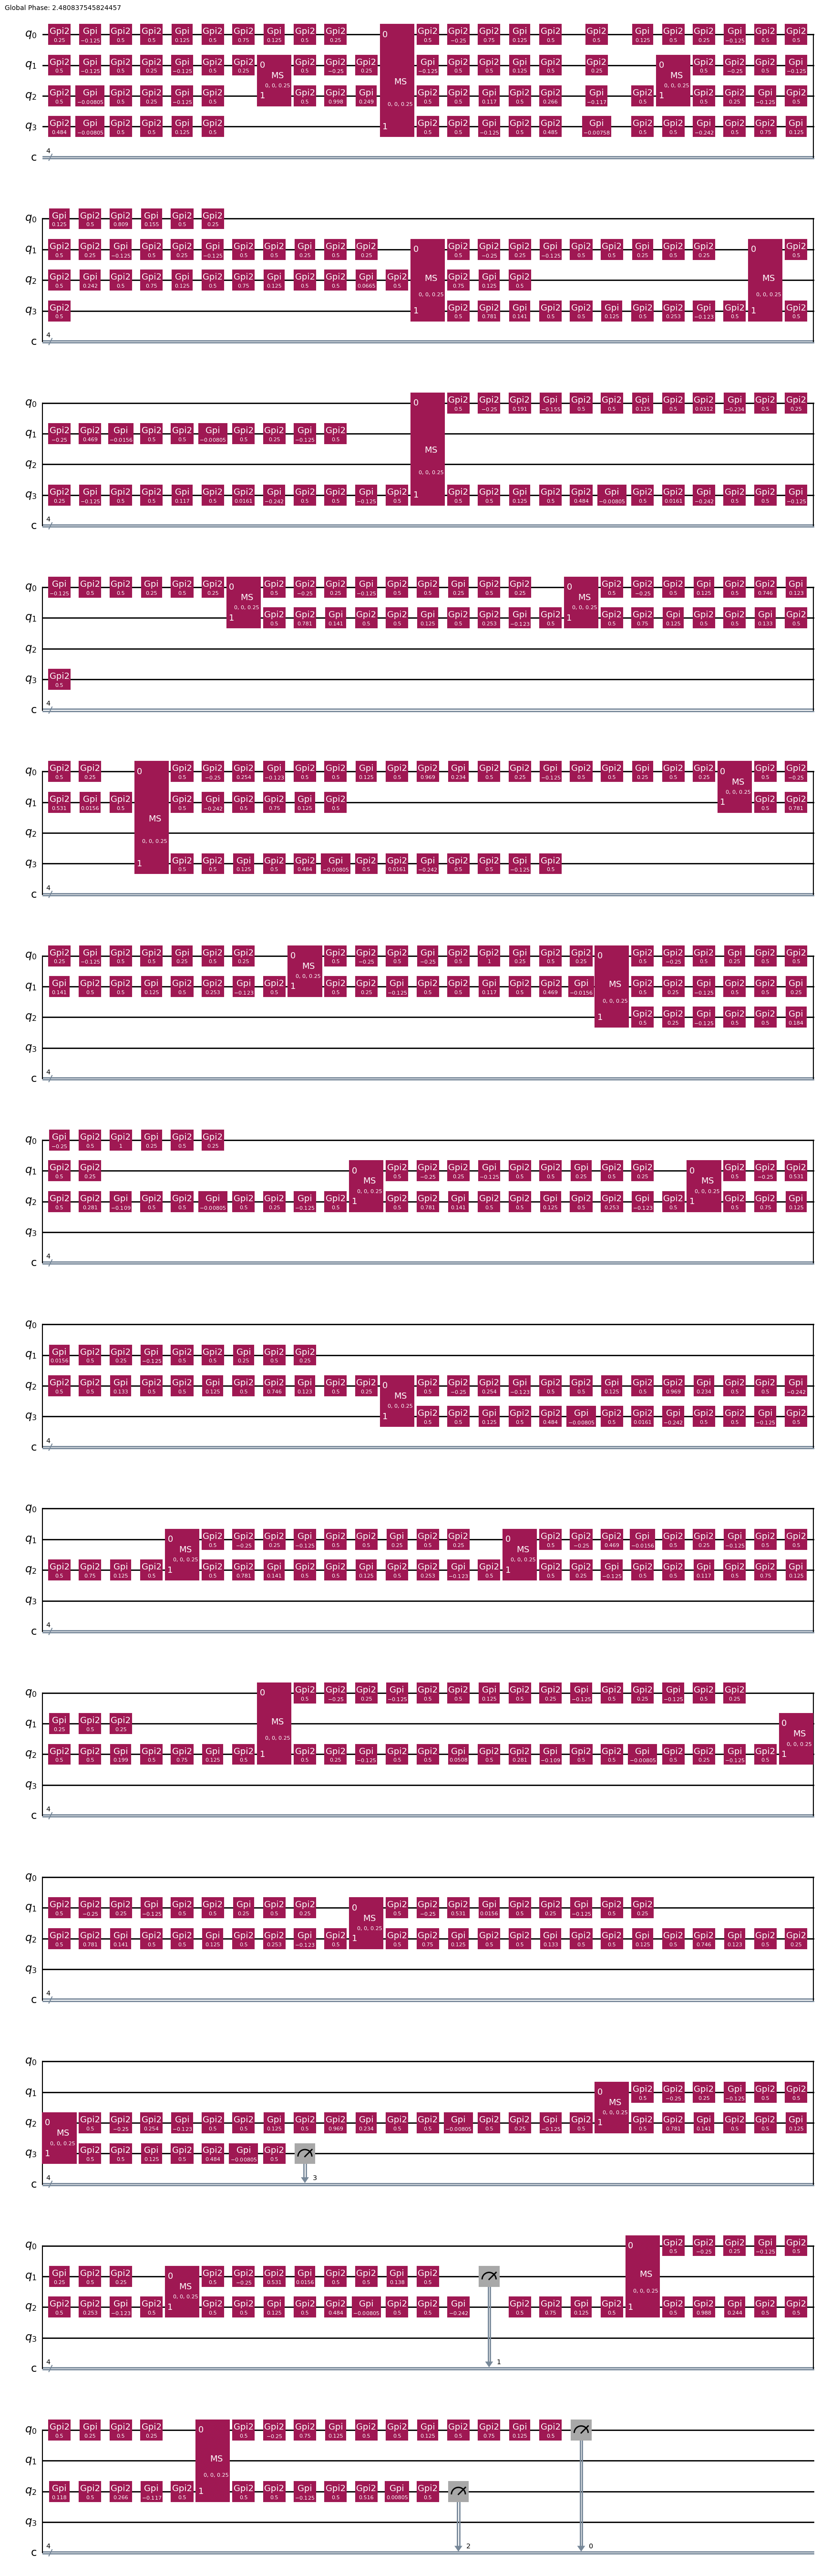

In [10]:
approach_name = "3_ucc_ionq_backend_native"

# Just use ionq_backend with native gateset "as-is" for ucc
ionq_backend = ionq_provider.get_backend("ionq_simulator", gateset="native")


ucc_ionq_circuit = ucc.compile(
    original_circuit,
    # target_device=BackendV2Converter(ionq_backend).target, <-- this breaks due to bug in UCC
    target_gateset=ionq_backend.configuration().basis_gates,
)

compiled_circuits[approach_name] = ucc_ionq_circuit
gateset[approach_name] = "native"
circuit_metrics[approach_name] = analyze_circuit_metrics(ucc_ionq_circuit)


print(f"✓ Approach 3: UCC (IonQ Backend, Native Gates)")
print(f"  Depth: {circuit_metrics[approach_name]['depth']}")
print(f"  Gates: {circuit_metrics[approach_name]['total_gates']}")
print(f"  2-qubit gates: {circuit_metrics[approach_name]['two_qubit_gates']}")
ucc_ionq_circuit.draw(output="mpl")

### Approach 4: Qiskit (Opt Level 3, QIS Gates)

✓ Approach 4: Qiskit (Opt Level 3, QIS Gates)
  Depth: 43
  Gates: 60
  2-qubit gates: 25


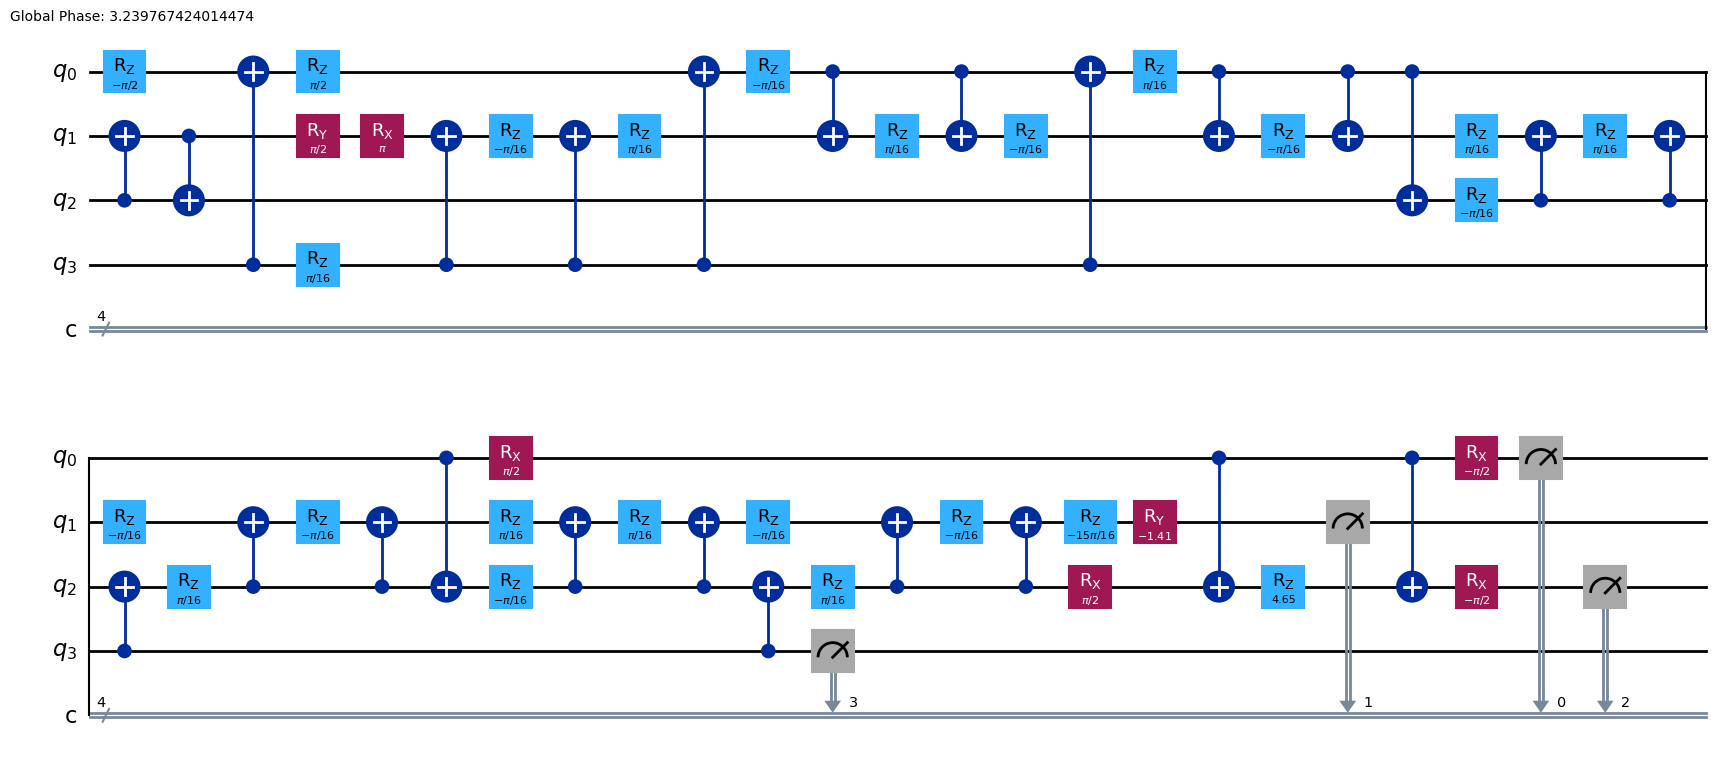

In [11]:
approach_name = "4_qiskit_opt3_qis"


qiskit_opt3_circuit = transpile(
    original_circuit, basis_gates=ionq_qis_gates, optimization_level=3
)


compiled_circuits[approach_name] = qiskit_opt3_circuit
gateset[approach_name] = "qis"
circuit_metrics[approach_name] = analyze_circuit_metrics(qiskit_opt3_circuit)


print(f"✓ Approach 4: Qiskit (Opt Level 3, QIS Gates)")
print(f"  Depth: {circuit_metrics[approach_name]['depth']}")
print(f"  Gates: {circuit_metrics[approach_name]['total_gates']}")
print(f"  2-qubit gates: {circuit_metrics[approach_name]['two_qubit_gates']}")
qiskit_opt3_circuit.draw(output="mpl")

### Approach 5: Qiskit (Opt Level 3, IonQ Backend, Native Gates)

✓ Approach 5: Qiskit (Opt Level 3, IonQ Backend, Native Gates)
  Depth: 122
  Gates: 222
  2-qubit gates: 25


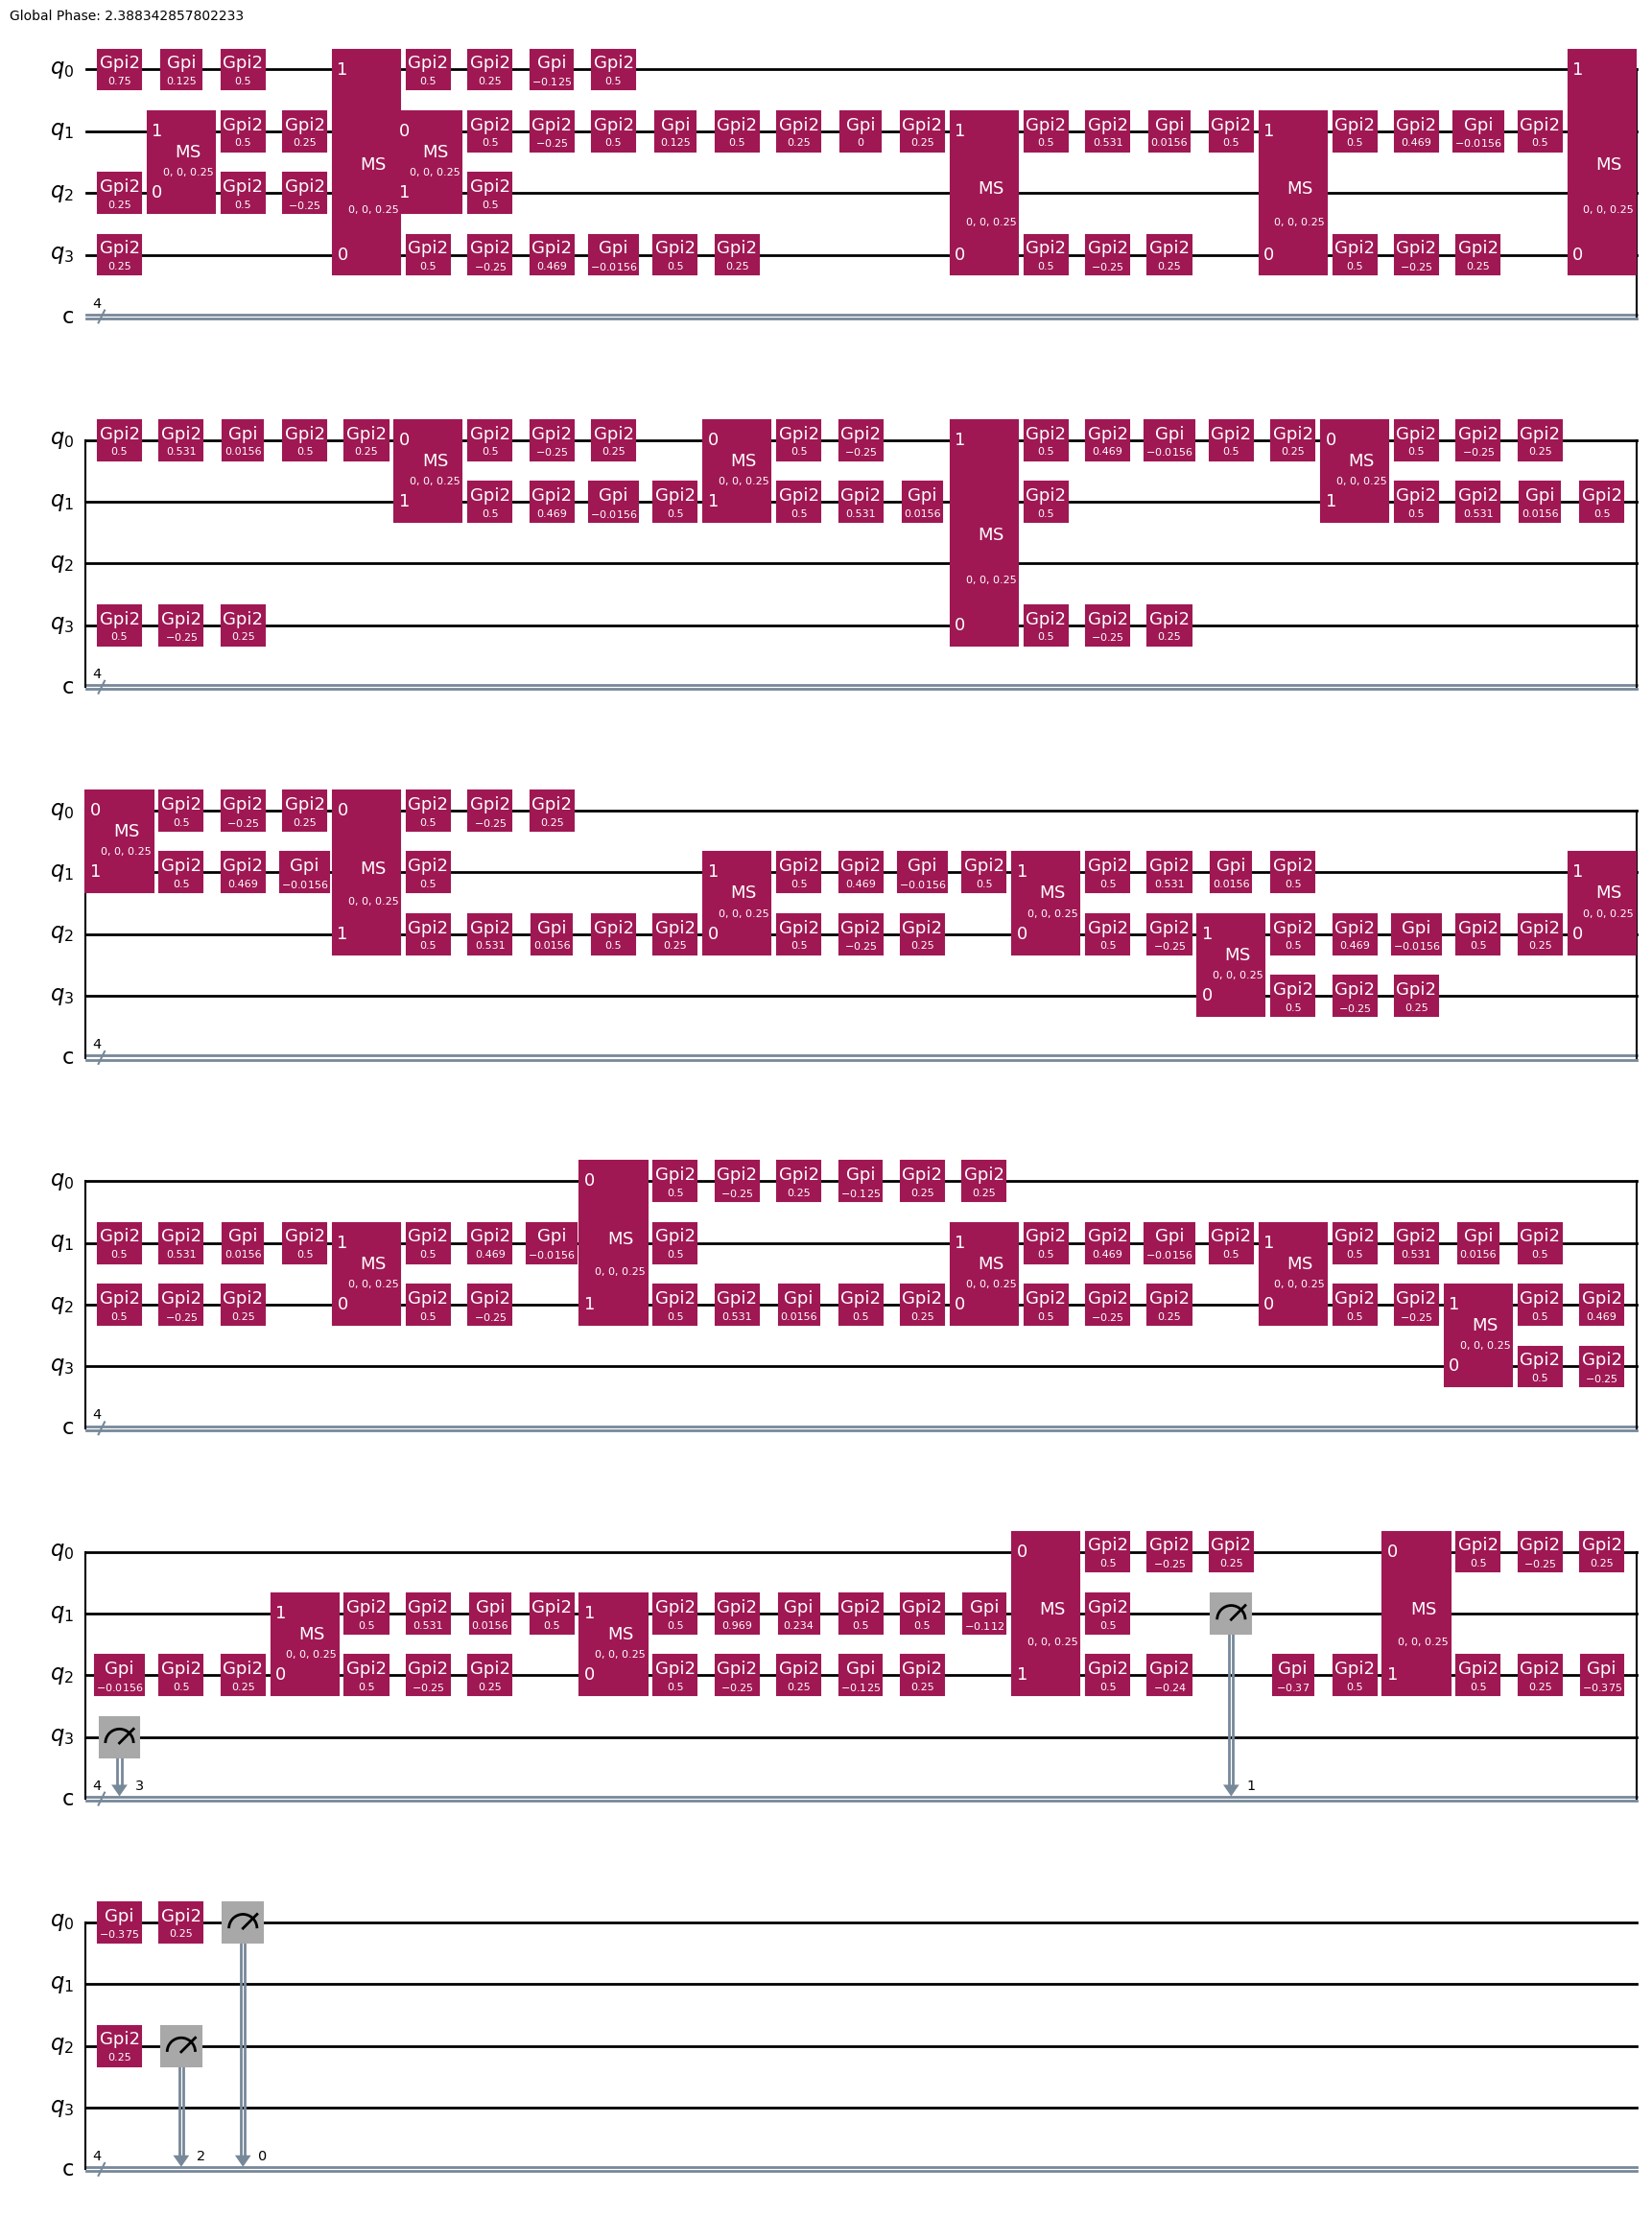

In [12]:
approach_name = "5_qiskit_opt3_ionq_backend_native"


ionq_backend = ionq_provider.get_backend("ionq_simulator", gateset="native")


qiskit_ionq_circuit = transpile(
    original_circuit, backend=ionq_backend, optimization_level=3
)


compiled_circuits[approach_name] = qiskit_ionq_circuit
gateset[approach_name] = "native"
circuit_metrics[approach_name] = analyze_circuit_metrics(qiskit_ionq_circuit)


print(f"✓ Approach 5: Qiskit (Opt Level 3, IonQ Backend, Native Gates)")
print(f"  Depth: {circuit_metrics[approach_name]['depth']}")
print(f"  Gates: {circuit_metrics[approach_name]['total_gates']}")
print(f"  2-qubit gates: {circuit_metrics[approach_name]['two_qubit_gates']}")
qiskit_ionq_circuit.draw(output="mpl")

## 4. Circuit Metrics Comparison

Compare the structural properties of all compiled circuits.

In [13]:
# Create comparison table
metrics_df = pd.DataFrame(circuit_metrics).T
metrics_df.index.name = "Approach"


# Calculate improvement percentages relative to original
original_metrics = circuit_metrics["1_original_uncompiled_qis"]
improvement_data = {}


for approach, metrics in circuit_metrics.items():
    if approach != "1_original_uncompiled_qis":
        depth_improvement = (
            (original_metrics["depth"] - metrics["depth"])
            / original_metrics["depth"]
            * 100
        )
        gate_improvement = (
            (original_metrics["total_gates"] - metrics["total_gates"])
            / original_metrics["total_gates"]
            * 100
        )

        improvement_data[approach] = {
            "depth_improvement_%": round(depth_improvement, 1),
            "gate_reduction_%": round(gate_improvement, 1),
        }


improvement_df = pd.DataFrame(improvement_data).T


print("=" * 80)
print("CIRCUIT METRICS COMPARISON")
print("=" * 80)
print("\nAbsolute Metrics:")
print(
    metrics_df[
        ["width", "depth", "total_gates", "two_qubit_gates", "native_gates"]
    ].to_string()
)


print("\nImprovement vs Original (+ is better):")
print(improvement_df.to_string())

CIRCUIT METRICS COMPARISON

Absolute Metrics:
                                  width depth total_gates two_qubit_gates native_gates
Approach                                                                              
1_original_uncompiled_qis             4    43          60              25            0
2_ucc_default_qis                     4   116         206              25            0
3_ucc_ionq_backend_native             4   338         660              25          656
4_qiskit_opt3_qis                     4    43          60              25            0
5_qiskit_opt3_ionq_backend_native     4   122         222              25          218

Improvement vs Original (+ is better):
                                   depth_improvement_%  gate_reduction_%
2_ucc_default_qis                               -169.8            -243.3
3_ucc_ionq_backend_native                       -686.0           -1000.0
4_qiskit_opt3_qis                                  0.0               0.0
5_qiskit_opt3

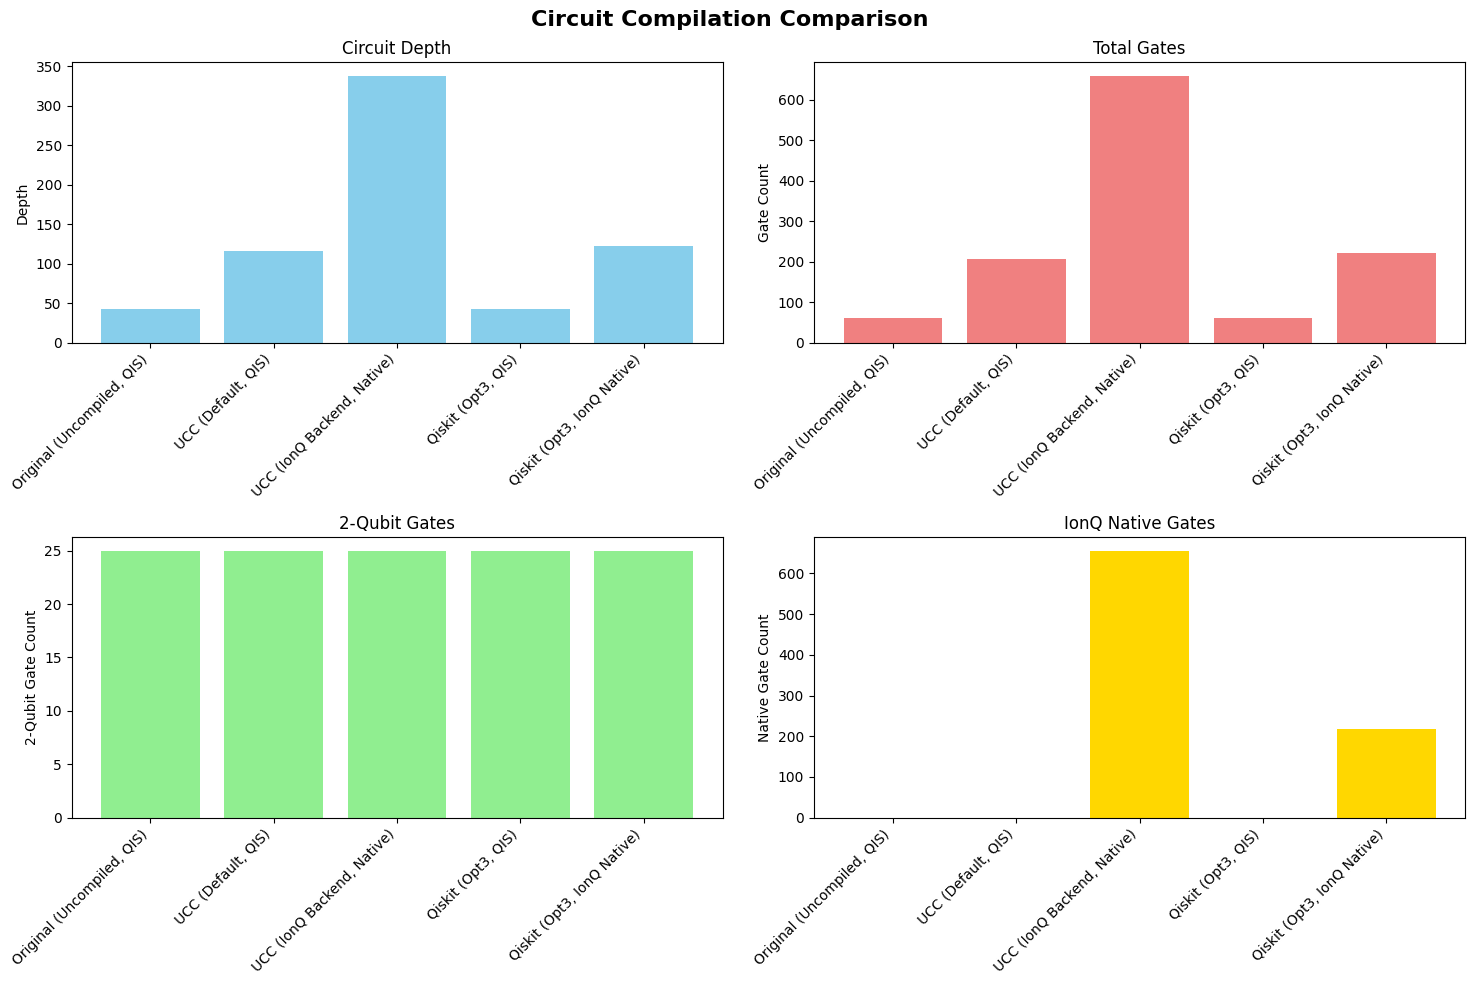

In [14]:
# Visualization of circuit metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Circuit Compilation Comparison", fontsize=16, fontweight="bold")


approaches = [
    "1_original_uncompiled_qis",
    "2_ucc_default_qis",
    "3_ucc_ionq_backend_native",
    "4_qiskit_opt3_qis",
    "5_qiskit_opt3_ionq_backend_native",
]
approach_labels = [
    "Original (Uncompiled, QIS)",
    "UCC (Default, QIS)",
    "UCC (IonQ Backend, Native)",
    "Qiskit (Opt3, QIS)",
    "Qiskit (Opt3, IonQ Native)",
]


# Circuit depth
depths = [circuit_metrics[app]["depth"] for app in approaches]
axes[0, 0].bar(range(len(approaches)), depths, color="skyblue")
axes[0, 0].set_title("Circuit Depth")
axes[0, 0].set_xticks(range(len(approaches)))
axes[0, 0].set_xticklabels(approach_labels, rotation=45, ha="right")
axes[0, 0].set_ylabel("Depth")


# Total gates
total_gates = [circuit_metrics[app]["total_gates"] for app in approaches]
axes[0, 1].bar(range(len(approaches)), total_gates, color="lightcoral")
axes[0, 1].set_title("Total Gates")
axes[0, 1].set_xticks(range(len(approaches)))
axes[0, 1].set_xticklabels(approach_labels, rotation=45, ha="right")
axes[0, 1].set_ylabel("Gate Count")


# 2-qubit gates
two_qubit_gates = [circuit_metrics[app]["two_qubit_gates"] for app in approaches]
axes[1, 0].bar(range(len(approaches)), two_qubit_gates, color="lightgreen")
axes[1, 0].set_title("2-Qubit Gates")
axes[1, 0].set_xticks(range(len(approaches)))
axes[1, 0].set_xticklabels(approach_labels, rotation=45, ha="right")
axes[1, 0].set_ylabel("2-Qubit Gate Count")


# Native gates (IonQ-specific)
native_gates = [circuit_metrics[app]["native_gates"] for app in approaches]
axes[1, 1].bar(range(len(approaches)), native_gates, color="gold")
axes[1, 1].set_title("IonQ Native Gates")
axes[1, 1].set_xticks(range(len(approaches)))
axes[1, 1].set_xticklabels(approach_labels, rotation=45, ha="right")
axes[1, 1].set_ylabel("Native Gate Count")


plt.tight_layout()
plt.show()

## 5. Performance Simulation and Total Variation Distance

Simulate all circuits and compare their output distributions using Total Variation Distance.

In [15]:
print("=" * 60)
print("PERFORMANCE SIMULATION")
print("=" * 60)


# Simulate all circuits
print(f"Running simulations with {NUM_SHOTS} shots...")
print(f"Noise model: {NOISE_MODEL}")


for approach_name in [
    "1_original_uncompiled_qis",
    "2_ucc_default_qis",
    "3_ucc_ionq_backend_native",
    "4_qiskit_opt3_qis",
    "5_qiskit_opt3_ionq_backend_native",
]:
    circuit = compiled_circuits[approach_name]
    try:
        print(f"  Simulating {approach_name}...")
        probs = simulate_circuit(
            circuit, gateset[approach_name], NUM_SHOTS, NOISE_MODEL
        )
        simulation_results[approach_name] = probs
    except Exception as e:
        print(f"  ⚠ Failed to simulate {approach_name}: {e}")
        simulation_results[approach_name] = {}  # Empty results


print("✓ All simulations completed")

PERFORMANCE SIMULATION
Running simulations with 5000 shots...
Noise model: aria-1
  Simulating 1_original_uncompiled_qis...


/Users/bchase/code/unitaryfoundation.research/ucc-hw-aware/.venv/lib/python3.13/site-packages/qiskit_ionq/ionq_backend.py:387: UserWarning: Option error_mitigation is not used by this backend
  return super().run(circuit, **kwargs)


  Simulating 2_ucc_default_qis...


/Users/bchase/code/unitaryfoundation.research/ucc-hw-aware/.venv/lib/python3.13/site-packages/qiskit_ionq/ionq_backend.py:387: UserWarning: Option error_mitigation is not used by this backend
  return super().run(circuit, **kwargs)


  Simulating 3_ucc_ionq_backend_native...


/Users/bchase/code/unitaryfoundation.research/ucc-hw-aware/.venv/lib/python3.13/site-packages/qiskit_ionq/ionq_backend.py:387: UserWarning: Option error_mitigation is not used by this backend
  return super().run(circuit, **kwargs)


  Simulating 4_qiskit_opt3_qis...


/Users/bchase/code/unitaryfoundation.research/ucc-hw-aware/.venv/lib/python3.13/site-packages/qiskit_ionq/ionq_backend.py:387: UserWarning: Option error_mitigation is not used by this backend
  return super().run(circuit, **kwargs)


  Simulating 5_qiskit_opt3_ionq_backend_native...


/Users/bchase/code/unitaryfoundation.research/ucc-hw-aware/.venv/lib/python3.13/site-packages/qiskit_ionq/ionq_backend.py:387: UserWarning: Option error_mitigation is not used by this backend
  return super().run(circuit, **kwargs)


✓ All simulations completed


In [16]:
# Calculate Total Variation Distances relative to original circuit
tvd_results = {}


print("\nTotal Variation Distance Analysis:")
print("(Distance from original circuit - lower is better)")
print("-" * 50)


# baseline_probs = exact_probs(original_circuit, NUM_SHOTS)
baseline_probs = simulation_results["1_original_uncompiled_qis"]


for approach_name in [
    "1_original_uncompiled_qis",
    "2_ucc_default_qis",
    "3_ucc_ionq_backend_native",
    "4_qiskit_opt3_qis",
    "5_qiskit_opt3_ionq_backend_native",
]:
    probs = simulation_results.get(approach_name, {})
    if probs:  # Skip original and failed simulations
        tvd = calculate_total_variation_distance(baseline_probs, probs, NUM_SHOTS)
        tvd_results[approach_name] = tvd
        print(f"{approach_name:30s}: {tvd:.4f}")


# Find best performing approach
if tvd_results:
    best_approach = min(tvd_results.items(), key=lambda x: x[1])
    print(
        f"\n✓ Best performing approach: {best_approach[0]} (TVD: {best_approach[1]:.4f})"
    )
else:
    print("\n⚠ No TVD results available")


Total Variation Distance Analysis:
(Distance from original circuit - lower is better)
--------------------------------------------------
1_original_uncompiled_qis     : 0.0000
2_ucc_default_qis             : 0.0156
3_ucc_ionq_backend_native     : 0.3122
4_qiskit_opt3_qis             : 0.0150
5_qiskit_opt3_ionq_backend_native: 0.2268

✓ Best performing approach: 1_original_uncompiled_qis (TVD: 0.0000)


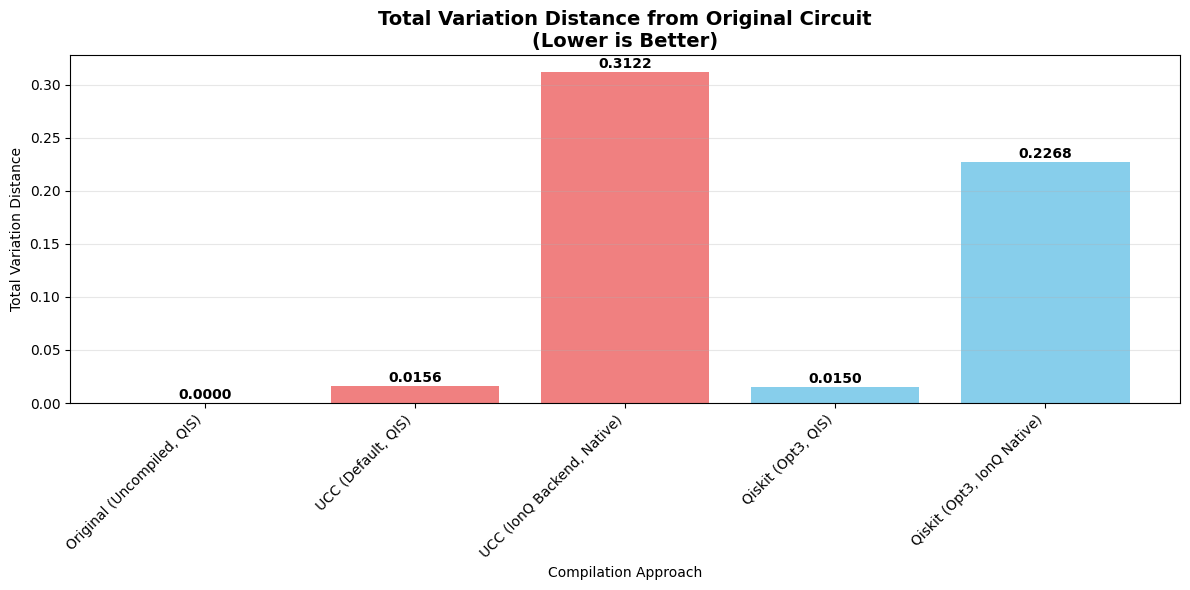

In [17]:
# Visualization of TVD results
if tvd_results:
    plt.figure(figsize=(12, 6))

    approaches = [
        "1_original_uncompiled_qis",
        "2_ucc_default_qis",
        "3_ucc_ionq_backend_native",
        "4_qiskit_opt3_qis",
        "5_qiskit_opt3_ionq_backend_native",
    ]
    tvd_values = [tvd_results.get(app, 0) for app in approaches]
    approach_labels = [
        "Original (Uncompiled, QIS)",
        "UCC (Default, QIS)",
        "UCC (IonQ Backend, Native)",
        "Qiskit (Opt3, QIS)",
        "Qiskit (Opt3, IonQ Native)",
    ]

    bars = plt.bar(
        range(len(approaches)),
        tvd_values,
        color=[
            "lightcoral" if "ucc" in app.lower() else "skyblue" for app in approaches
        ],
    )

    plt.title(
        "Total Variation Distance from Original Circuit\n(Lower is Better)",
        fontsize=14,
        fontweight="bold",
    )
    plt.xlabel("Compilation Approach")
    plt.ylabel("Total Variation Distance")
    plt.xticks(range(len(approaches)), approach_labels, rotation=45, ha="right")

    # Add value labels on bars
    for bar, value in zip(bars, tvd_values):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.001,
            f"{value:.4f}",
            ha="center",
            va="bottom",
            fontweight="bold",
        )

    plt.tight_layout()
    plt.grid(axis="y", alpha=0.3)
    plt.show()
else:
    print("No TVD visualization available")

## Take-aways

* For this random circuit (over a few different seeds), we definitely see worse performance for both UCC and Qiskit using the IonQ native backend, versus relying on the cloud provider to go from QIS to native gates. 
* UCC has worse performance than Qiskit compling to the native gates via the IonQ backend.
* UCC to QIS gates has worse performance even without the IonQ backend.